# Secret Messages Using Chaos!

This notebook runs through a real-world application of chaos. It uses the Lorentz chaos differential equations to mask a secret message with noise, as well as unmask that signal once it's received. It follows logic outlined in Strogatz's "Nonlinear Dynamics and Chaos". 

All the user needs to do is define a .wav file of their secret message (see below cell), and click run all. 

It is reccomended to collapse all code cells, so that the outputs are clearly visible. Comments at the top of code cells will still be visible, and will keep the user updated on what the code is doing.

The code has 3 outputs: 'noise.wav', 'signal.wav', and 'recoveredmessage.wav' 

In [1]:
## CHOOSE MESSAGE YOU WANT TO WORK WITH:
# must be a .wav file

filename = "phone.wav"

## Imports and Definitions

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import IPython
import wavio
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline

def Lorentz(t,a):
    u = a[0] # unpack x
    v = a[1] # unpack y
    w = a[2] # unpack z
    dotu = 16*(v-u)
    dotv = u*(45.6-20*w)-v
    dotw = 5*u*v - 4*w
    return np.array([dotu,dotv,dotw]) # return vector of derivatives


## Create encoded signal

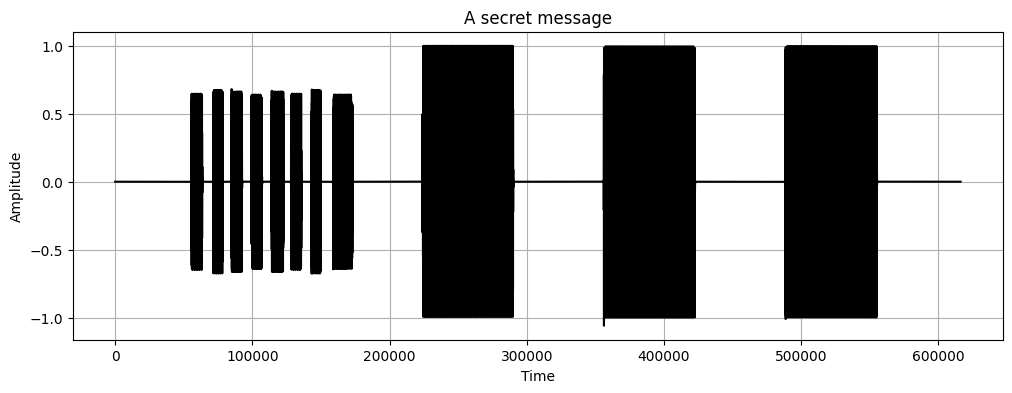

In [15]:
# get secret 'message'

k = wavio.read(filename)
sample_rate = k.rate
audio_data = k.data[:,0]/np.abs(k.data.max())

fig,ax = plt.subplots(figsize=(12,4))
ax.plot(np.arange(len(audio_data)),audio_data,label="x",c="k")
ax.set_xlabel("Time")
ax.set_ylabel("Amplitude")
ax.set_title("A secret message")
ax.grid();

IPython.display.Audio(filename)

In [4]:
#demonstrate creation of chaos

ic = np.array([-2.3, -1.9, 2.2])  # Initial conditions
tend = len(audio_data) / sample_rate  # Calculate the duration of the audio file
t = np.linspace(0, tend, len(audio_data))  # Times for simulation
sol = solve_ivp(Lorentz, [0, tend], ic, t_eval=t, atol=1e-9, rtol=1e-8)

u = sol.y[0,:] # extract x(t)
v = sol.y[1,:] # extract y(t)
w = sol.y[2,:] # extract z(t)


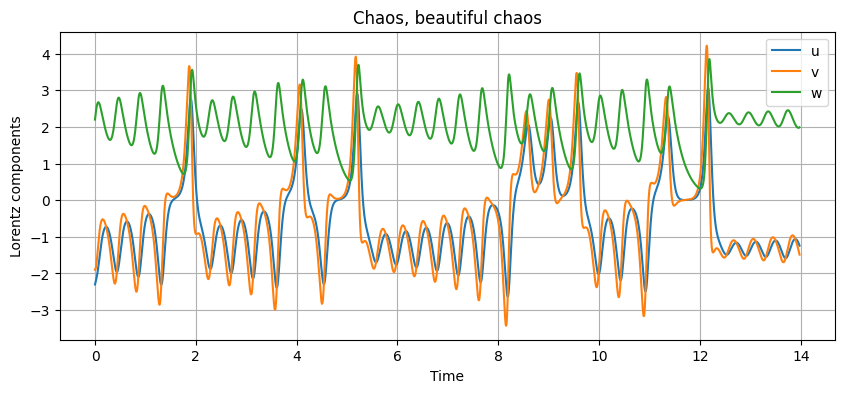

In [5]:
#plot
fig,ax = plt.subplots(figsize=(10,4))
ax.plot(t,u,label="u")
ax.plot(t,v,label="v")
ax.plot(t,w,label="w")
ax.set_xlabel("Time")
ax.set_ylabel("Lorentz components")
ax.set_title("Chaos, beautiful chaos")
ax.legend()
ax.grid();

In [6]:
#generate high-freq chaos (noise)

ic = np.array([-2.3, -1.9, 2.2])  # Initial conditions
tend = 10000 
t = np.linspace(0, tend, len(audio_data))  # Times for simulation
sol = solve_ivp(Lorentz, [0, tend], ic, t_eval=t, atol=1e-9, rtol=1e-8)

u = sol.y[0,:] # extract u(t)




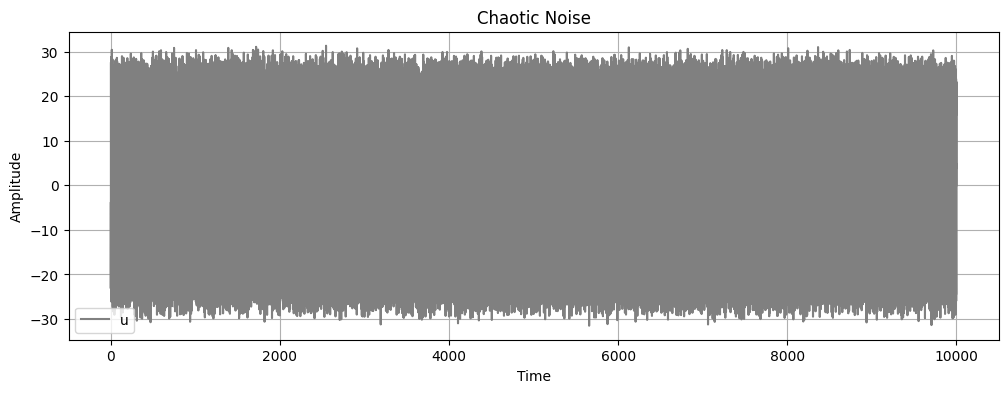

In [7]:
#ensure noise is high-amplitude and plot

if u.max() < 10:
    u *= 10

wavio.write("noise.wav", u,sample_rate, sampwidth=2)
IPython.display.Audio("noise.wav")

fig,ax = plt.subplots(figsize=(12,4))
ax.plot(t,u,label="u",c='gray')
ax.set_xlabel("Time")
ax.set_ylabel("Amplitude")
ax.set_title("Chaotic Noise")
ax.legend()
ax.grid();

In [8]:
# Add noise to create masked signal

signal = u + audio_data
wavio.write("signal.wav",signal,44100,sampwidth=2)
IPython.display.Audio("signal.wav")

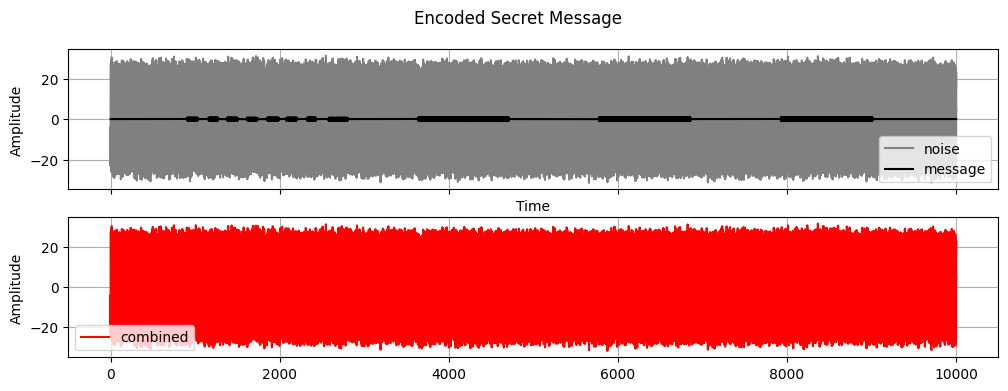

In [9]:
#visualize our progress so far

fig,ax = plt.subplots(nrows=2,figsize=(12,4),sharex=True)
ax[0].plot(t,u,label="noise",c='gray')
ax[1].plot(t,signal,label="combined",c='red')
ax[0].plot(t,audio_data,label="message",c='k')
ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Amplitude")
ax[1].set_ylabel("Amplitude")
fig.suptitle("Encoded Secret Message");


## Recover the message

In [10]:
#extract original 'u'
ufun = CubicSpline(t,signal)
interp_sig = ufun(t)
interp_sig /=10


In [12]:
#reconstruct noise

def Lorentz2(tt,a):
    assert np.isscalar(tt)
    U = a[0]
    V = a[1]
    W = a[2]
    uu = ufun(tt)/10
    dotU = 16*(V-U)
    dotV = uu*(45.6-20*W)-V
    dotW = 5*uu*V - 4*W
    return np.array([dotU,dotV,dotW])

tend = 10000 # simulation end time
sol = solve_ivp(Lorentz2,[0,tend],ic,t_eval=t,atol=1e-9,rtol=1e-8) # :) :) :)
assert sol.success
U = sol.y[0,:] # extract U(t)

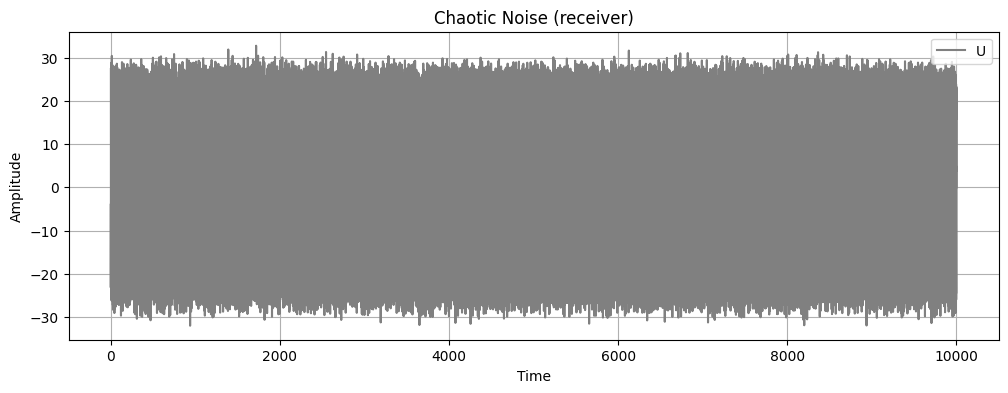

In [13]:
#plot

if U.max() < 10:
    U *= 10
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(t,U,label="U",color='grey')
ax.set_xlabel("Time")
ax.set_ylabel("Amplitude")
ax.set_title("Chaotic Noise (receiver)")
ax.legend()
ax.grid();

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/crinkosk/mambaforge/envs/mathproj/lib/python3.12/site-packages/wavio.py:259: ClippedDataWarning: Some data values have been clipped.  With scale=1.0, the interval of input values that will not be clipped is [-1.0000305180437934, 1.0]
  _warnings.warn(ClippedDataWarning(msg))


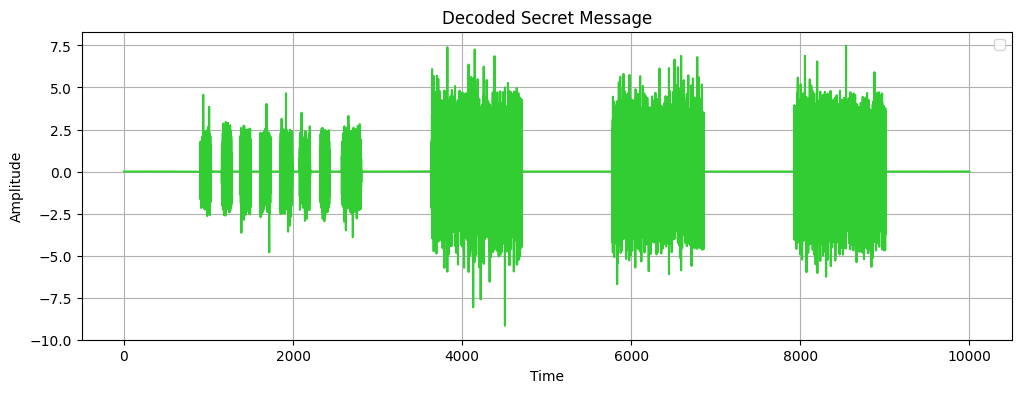

In [14]:
#subtract new noise from signal (recovering the message!)
recoveredmusic = signal - U

fig,ax = plt.subplots(figsize=(12,4))
ax.plot(t,recoveredmusic,color='limegreen')
ax.set_xlabel("Time")
ax.set_ylabel("Amplitude")
ax.set_title("Decoded Secret Message")
ax.legend()
ax.grid();

wavio.write("recoveredmessage.wav",recoveredmusic,44100,sampwidth=2)
IPython.display.Audio("recoveredmessage.wav")